In [1]:
from sumo_deeprl import SumoDeepRl
import os
import traci
from stable_baselines3.dqn.dqn import DQN

### Init Sumo-DeepRl class

In [2]:
junction = 'simple_2_intersection'
junction = 'saint_paul'
#reward = 'average-speed'
#reward = 'pressure'
reward = 'queue'
sim_time='1.0hour'
time = 24*3600
vphs = [1000,2000,3000,4000,5000]

In [3]:
sumo = SumoDeepRl(junction_name=junction)

### Generate Trips (optional)

In [ ]:
route_details = {'n': ['-E1', 2], 
                 's': ['-E3', 3],
                 'e': ['E0', 4],
                 'w': ['-E2', 3]}
route_details = {'n': ['-E2', 4], 
                 's': ['-E0', 3],
                 'e': ['-E3', 2],
                 'w': ['-E1', 3]}
for cars in vphs:
  sumo.create_routes(route_details=route_details, time=time, total_cars=cars)

### Simulation

In [ ]:
# sumo.simulation(sim_time=sim_time,route_file='3000.rou.xml', useGui=False)
sumo.analyze_fixed(sim_time=sim_time,vphs=vphs, useGui=False)

In [ ]:
traci.close()

### Model

In [4]:
"""
reward_fns = {
  "diff-waiting-time": _diff_waiting_time_reward, # sum waiting time(t) - sum waiting time(t+1)
  "average-speed": _average_speed_reward, # average speed of every car
  "queue": _queue_reward, # -1 * total number of halting cars
  "pressure": _pressure_reward, # Returns the pressure (#veh leaving - #veh approaching) of the intersection.
}
"""

train_num_veh = '3000'

env = sumo.create_environment(sim_time=sim_time,route_file=f'{train_num_veh}.rou.xml', num_seconds=100000,yellow_time=5, reward_fn=reward)

In [5]:
model = DQN(
  env=env,
  policy="MlpPolicy",
  learning_starts=0,
  train_freq=1,
  exploration_initial_eps=0.05,
  exploration_final_eps=0.01,
  verbose=1
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
total_timesteps = 100000
model.learn(total_timesteps=total_timesteps, reset_num_timesteps=False)


out_dir = f"{junction}/{sim_time}/model/{reward}"
if not os.path.exists(out_dir):
  os.makedirs(out_dir)
fullname = os.path.join(out_dir, train_num_veh)   
model.save(fullname)
env.close()

### Result from model

In [6]:
train_model = DQN.load(f'{junction}/{sim_time}/model/{reward}/{train_num_veh}.zip', env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [7]:
#sumo.predict(sim_time=sim_time,route_file='5000.rou.xml', model=train_model, useGui=True, yellow_time=5)
sumo.analyze_predict(model=train_model, sim_time=sim_time, vphs=vphs, trained_number_veh=train_num_veh, reward=reward,yellow_time=5)

1000 cars: waiting time 205590.0, clear time: 80904.0
2000 cars: waiting time 279901.0, clear time: 100002.0
3000 cars: waiting time 318989.0, clear time: 100002.0
4000 cars: waiting time 389165.0, clear time: 100002.0
5000 cars: waiting time 440174.0, clear time: 100002.0


## Saint Paul

In [ ]:
junction = 'saint_paul'
reward = 'diff-waiting-time'
sim_time='1.0hour'
vphs = [1000, 2000, 3000, 4000, 5000]

In [ ]:
sumo = SumoDeepRl(junction_name=junction)

In [ ]:
sumo.analyze_fixed(sim_time='1.0hour',vphs=[1000, 2000, 3000, 4000, 5000], useGui=False)

In [ ]:
env = sumo.create_environment(sim_time=sim_time,route_file='3000.rou.xml',num_seconds=15000,yellow_time=5, reward_fn=reward)

In [ ]:
train_model = DQN.load(f'{junction}/1.0hour/model/{reward}/3000.zip', env=env)

In [ ]:
sumo.predict(sim_time=sim_time,route_file='3000.rou.xml', model=train_model, useGui=True, yellow_time=5)

In [ ]:
traci.close()

In [ ]:
sumo.analyze_predict(model=train_model,
                     sim_time=sim_time,
                     vphs=vphs,
                     trained_number_veh='3000',
                     reward=reward,
                     yellow_time=5)

In [ ]:
traci.close()

## Table

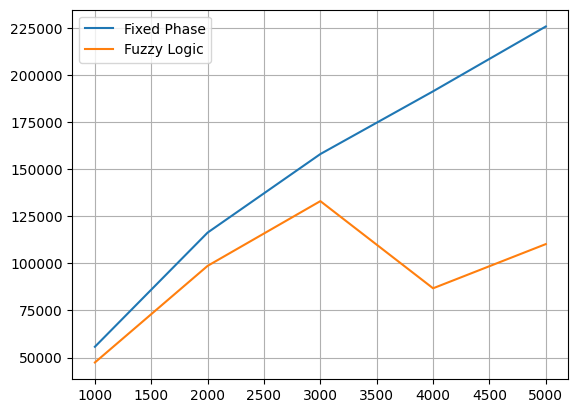

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./saint_paul_1hr.csv')

plt.plot(df['vehicle per hour'], df['waiting_fixed'], label = "Fixed Phase")
plt.plot(df['vehicle per hour'], df['fuzzy_total_waiting_time'], label = "Fuzzy Logic")
plt.grid()
plt.legend()
plt.show()

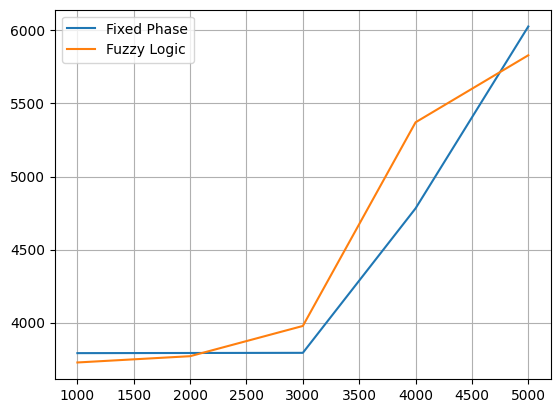

In [4]:
plt.plot(df['vehicle per hour'], df['clear_fixed'], label = "Fixed Phase")
plt.plot(df['vehicle per hour'], df['fuzzy_total_clear_time'], label = "Fuzzy Logic")
plt.grid()
plt.legend()
plt.show()